In [85]:
%%capture --no-stderr
%pip install uv
%uv pip install chromadb==0.4.22
%uv pip install tiktoken==0.9.0
%uv pip install langchain==0.3.20
%uv pip install langchain-community==0.3.10
%uv pip install langchain-openai==0.3.1
%uv pip install langchainhub
%uv pip install langchain-text-splitters==0.3.6
%uv pip install langgraph==0.3.1
%uv pip install openai==1.65.3
%uv pip install PyMuPDF==1.25.3
%uv pip install pypdf==5.3.1
%uv pip install pillow==11.1.0
%uv pip install beautifulsoup4==4.13.3

In [91]:
%pip install pandas
%pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 16.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from IPython.display import Image as IPImage
from IPython.display import Image, display
import json

from typing import Any
from typing_extensions import TypedDict
import operator
from typing import Annotated


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.graph.message import add_messages
%pip show chromadb
%pip show langchain
%pip show langchain-openai
%pip show langchainhub
%pip show langgraph
import os

Name: chromadb
Version: 0.4.22
Summary: Chroma.
Home-page: https://github.com/chroma-core/chroma
Author: 
Author-email: Jeff Huber <jeff@trychroma.com>, Anton Troynikov <anton@trychroma.com>
License: 
Location: /Users/hannahgraham/Desktop/AIAgents/venv/lib/python3.10/site-packages
Requires: bcrypt, build, chroma-hnswlib, fastapi, grpcio, importlib-resources, kubernetes, mmh3, numpy, onnxruntime, opentelemetry-api, opentelemetry-exporter-otlp-proto-grpc, opentelemetry-instrumentation-fastapi, opentelemetry-sdk, overrides, posthog, pulsar-client, pydantic, pypika, PyYAML, requests, tenacity, tokenizers, tqdm, typer, typing-extensions, uvicorn
Required-by: langchain-chroma
Note: you may need to restart the kernel to use updated packages.
Name: langchain
Version: 0.3.20
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /Users/hannahgraham/Desktop/AIAgents/venv/lib/python3.10/site-packages
Requires: async-timeout, langc

In [53]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


True

In [54]:
# Requirement 1: Define the structure of agent state for the LangGraph
class InquiryState(TypedDict):
    inquiry: str
    next_node: str
    response: str  


In [56]:
def operator_router(state):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    query = f"""Classify the user's intents based on the following input: '{state['inquiry']}'. 
            List of possible intent values: Greeting, Marketing, Data Science, Membership/Fraud, Order/Shipping, ProductRecommendation.
            Return only the intent value of the inquiry identified with no extra text or characters"""
    
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
        ],
    )

    system_message = SystemMessage(content="You are a helpful assistant tasked with classifying the intent of user's inquiry")
    
    response = llm.invoke([system_message]+[human_message])
    intent = response.content.strip()
    response_lower = intent.lower()

    # Map LLM output to node names
    intent_map = {
        "productrecommendation": "ProductRecommendation",
        "order/shipping": "Order",
        "membership/fraud": "Membership",
        "datascience": "DataScience",
        "marketing": "Marketing",
        "greeting": END,
        "generalinquiry": END
    }

    mapped_intent = intent_map.get(response_lower.replace(" ", ""), intent)

    if mapped_intent == END:
        if "greeting" in response_lower:
            response = "Hello there, This is Northwestern Memorial Hospital, How can I assisst you today?"
        else:
            response = "For general informtion about Peloton, please visit our website at: https://www.onepeloton.com/"
        next_node = END
    else:
        response = None
        next_node = mapped_intent

    return {
        "inquiry": state["inquiry"],
        "next_node": next_node,
        "response": response
    }

In [57]:
def productRecommenderAgent(state):

    # Load the knowledge base from the JSON-formatted .txt file
    knowledge_base_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/peloton_knowledge_base.txt"
    with open(knowledge_base_path, "r") as file:
        knowledge_base = json.load(file)

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    query = f"""Provide an answer for the following user's inquiry about Peloton products: '{state['inquiry']}' using the knowledge_base"""

    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
        ],
    )

    system_message = SystemMessage(
        content=f"You are a helpful Peloton assistant tasked with answering user's inquiry based on the answers you have in this knowledge_base only: {json.dumps(knowledge_base)}"
    )

    response = llm.invoke([system_message] + [human_message])
    formatted_response = "Product Agent: " + response.content.strip()

    return {"inquiry": state["inquiry"], "next_node": END, "response": formatted_response}

In [67]:
import re
import csv

def orderAgent(state):
    knowledge_base_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/peloton_knowledge_base.txt"
    order_csv_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/order_status.csv"
    with open(knowledge_base_path, "r") as file:
        knowledge_base = json.load(file)

    user_inquiry = state['inquiry'].strip().lower()
    matched_entry = None

    # 1. Try to find a matching inquiry in the knowledge base
    for entry in knowledge_base:
        if entry["inquiry"].strip().lower() == user_inquiry:
            matched_entry = entry
            break

    if matched_entry:
        response_text = matched_entry["response"]
    else:
        # 2. Try to extract an order number from the inquiry
        match = re.search(r'order number\s*is\s*([A-Za-z0-9\-]+)', user_inquiry)
        if match:
            order_number = match.group(1)
            # 3. Check the CSV for the order status
            found = False
            with open(order_csv_path, newline='') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if row['order_number'].strip().lower() == order_number.lower():
                        response_text = f"Order Agent: The status of order {order_number} is: {row['status']}."
                        found = True
                        break
            if not found:
                response_text = f"Order Agent: Sorry, I could not find the status for order {order_number}."
        else:
            # 4. Fallback to LLM
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
            query = f"""Provide an answer for the following user's inquiry about Peloton orders: '{state['inquiry']}'"""
            human_message = HumanMessage(content=[{"type": "text", "text": query}])
            system_message = SystemMessage(content="You are a helpful Peloton assistant. Answer the user's inquiry as best as you can.")
            llm_response = llm.invoke([system_message, human_message])
            response_text = "Order Agent: " + llm_response.content.strip()

    return {"inquiry": state["inquiry"], "next_node": END, "response": response_text}

In [71]:
def membershipAgent(state):
    import re
    import csv

    knowledge_base_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/peloton_knowledge_base.txt"
    order_csv_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/order_status.csv"
    with open(knowledge_base_path, "r") as file:
        knowledge_base = json.load(file)

    user_inquiry = state['inquiry'].strip().lower()
    matched_entry = None

    # Try to find a matching inquiry in the knowledge base
    for entry in knowledge_base:
        if entry["inquiry"].strip().lower() == user_inquiry:
            matched_entry = entry
            break

    if matched_entry:
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        query = f"""Provide an answer for the following user's inquiry about Peloton memberships: '{state['inquiry']}' using the knowledge_base"""
        human_message = HumanMessage(content=[{"type": "text", "text": query}])
        system_message = SystemMessage(content=f"You are a helpful Peloton assistant tasked with answering user's inquiry based on the answers you have in this knowledge_base only: {json.dumps(knowledge_base)}")
        response = llm.invoke([system_message] + [human_message])
        formatted_response = "Membership Agent: " + response.content.strip()
        return {"inquiry": state["inquiry"], "next_node": END, "response": formatted_response}
    else:
        # Check for fraud flagging intent and transaction/order ID
        if "flag" in user_inquiry and "fraud" in user_inquiry:
            match = re.search(r'id\s*([A-Za-z0-9\-]+)', user_inquiry)
            if match:
                order_id = match.group(1)
                # Update the fraudulent column in the CSV
                rows = []
                updated = False
                # Read all rows and update if order_number matches
                with open(order_csv_path, newline='') as csvfile:
                    reader = csv.DictReader(csvfile)
                    fieldnames = reader.fieldnames
                    # Add 'fraudulent' column if not present
                    if 'fraudulent' not in fieldnames:
                        fieldnames.append('fraudulent')
                    for row in reader:
                        if row['order_number'].strip().lower() == order_id.lower():
                            row['fraudulent'] = 'true'
                            updated = True
                        elif 'fraudulent' not in row:
                            row['fraudulent'] = ''
                        rows.append(row)
                # Write back to CSV
                with open(order_csv_path, 'w', newline='') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    writer.writeheader()
                    writer.writerows(rows)
                if updated:
                    response_text = "Your report has been received. Our team will investigate and contact you."
                else:
                    response_text = "Sorry, we could not find that transaction ID. Please check and try again."
                return {"inquiry": state["inquiry"], "next_node": END, "response": response_text}
        # Fallback to LLM for other membership questions
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        query = f"""Provide an answer for the following user's inquiry about Peloton memberships: '{state['inquiry']}' using the knowledge_base"""
        human_message = HumanMessage(content=[{"type": "text", "text": query}])
        system_message = SystemMessage(content=f"You are a helpful Peloton assistant tasked with answering user's inquiry based on the answers you have in this knowledge_base only: {json.dumps(knowledge_base)}")
        response = llm.invoke([system_message] + [human_message])
        formatted_response = "Membership Agent: " + response.content.strip()
        return {"inquiry": state["inquiry"], "next_node": END, "response": formatted_response}

In [106]:
def dataScienceAgent(state):
    import pandas as pd
    import re

    knowledge_base_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/peloton_knowledge_base.txt"
    with open(knowledge_base_path, "r") as file:
        knowledge_base = json.load(file)

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Try to extract a CSV path from the inquiry if not already provided
    csv_path = state.get("csv_path", None)
    if not csv_path:
        match = re.search(r'csv:\s*([^\s,]+)', state["inquiry"])
        if match:
            csv_path = match.group(1)

    if csv_path:
        try:
            df = pd.read_csv(csv_path)
            summary = df.describe(include='all').to_string()
            head = df.head().to_string()
            csv_summary = f"Workout Data (first rows):\n{head}\n\nStatistics:\n{summary}"

            query = (
                f"Analyze the following Peloton workout data and provide a summary and suggestions "
                f"on how the user can improve their performance. Also answer this inquiry: '{state['inquiry']}'.\n\n"
                f"{csv_summary}"
            )

            human_message = HumanMessage(
                content=[
                    {"type": "text", "text": query}
                ]
            )
            system_message = SystemMessage(
                content="You are a helpful Peloton data science assistant. Analyze the user's workout CSV data and provide actionable advice."
            )
            response = llm.invoke([system_message, human_message])
            formatted_response = "Data Science Agent (CSV Analysis): " + response.content.strip()
        except Exception as e:
            formatted_response = f"Data Science Agent: There was an error reading your CSV file: {e}"
    else:
        query = f"""Provide an answer for the following user's inquiry about Peloton data science: '{state['inquiry']}' using the knowledge_base"""
        human_message = HumanMessage(
            content=[
                {"type": "text", "text": query},
            ],
        )
        system_message = SystemMessage(
            content=f"You are a helpful Peloton assistant tasked with answering user's inquiry based on the answers you have in this knowledge_base only: {json.dumps(knowledge_base)}"
        )
        response = llm.invoke([system_message] + [human_message])
        formatted_response = "Data Science Agent: " + response.content.strip()

    return {"inquiry": state["inquiry"], "next_node": END, "response": formatted_response}

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import display, Image as IPImage
def marketingAgent(state):

    knowledge_base_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/peloton_knowledge_base.txt"
    campaign_csv_path = "/Users/hannahgraham/Desktop/AIAgents/final_project/knowledge_base/campaign_data.csv"
    with open(knowledge_base_path, "r") as file:
        knowledge_base = json.load(file)

    user_inquiry = state['inquiry'].strip().lower()
    matched_entry = None

    # Try to find a matching inquiry in the knowledge base
    for entry in knowledge_base:
        if entry["inquiry"].strip().lower() == user_inquiry:
            matched_entry = entry
            break

    # Special handling for revenue trends visualization
    if "revenue trends" in user_inquiry and "marketing campaign" in user_inquiry:
        # Read the campaign data
        df = pd.read_csv(campaign_csv_path)
        plt.figure(figsize=(8, 5))
        plt.bar(df["Campaign Name"], df["Revenue ($)"], color='skyblue', label="Revenue ($)")
        plt.bar(df["Campaign Name"], df["Budget ($)"], color='orange', alpha=0.6, label="Budget ($)")
        plt.ylabel("Amount ($)")
        plt.title("Peloton Marketing Campaigns: Revenue vs Budget")
        plt.xticks(rotation=30, ha='right')
        plt.legend()
        plt.tight_layout()

        # Save plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        # Display in notebook
        display(IPImage(data=buf.getvalue()))
        response_text = "Marketing Agent: Here is the revenue vs. budget visualization for Peloton’s marketing campaigns."
        return {"inquiry": state["inquiry"], "next_node": END, "response": response_text}

    if matched_entry:
        response_text = matched_entry["response"]
    else:
        # If not found, use the LLM to answer
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        query = f"""Provide a marketing-focused answer for the following user's inquiry about Peloton: '{state['inquiry']}'"""
        human_message = HumanMessage(content=[{"type": "text", "text": query}])
        system_message = SystemMessage(content="You are a helpful Peloton marketing assistant. Answer the user's inquiry as best as you can.")
        llm_response = llm.invoke([system_message, human_message])
        response_text = llm_response.content.strip()

    formatted_response = "Marketing Agent: " + response_text
    return {"inquiry": state["inquiry"], "next_node": END, "response": formatted_response}

In [108]:


builder = StateGraph(InquiryState)
# Add the Operator node
builder.add_node("Operator", operator_router)
# Update the builder to include the new agents
builder.add_node("ProductRecommendation", productRecommenderAgent)
builder.add_node("Order", orderAgent)
builder.add_node("Membership", membershipAgent)
builder.add_node("DataScience", dataScienceAgent)
builder.add_node("Marketing", marketingAgent)


builder.set_entry_point("Operator")

# Update the conditional edges in the orchestrator
builder.add_conditional_edges(
    "Operator",
    lambda x: x["next_node"],
    {
        "ProductRecommendation": "ProductRecommendation",
        "Order": "Order",
        "Membership": "Membership",
        "DataScience": "DataScience",
        "Marketing": "Marketing",
        END: END,
    },
)

# Add edges to end nodes for the new agents
builder.add_edge("Order", END)
builder.add_edge("Membership", END)
builder.add_edge("DataScience", END)
builder.add_edge("Marketing", END)

# Compile the updated graph
graph = builder.compile()

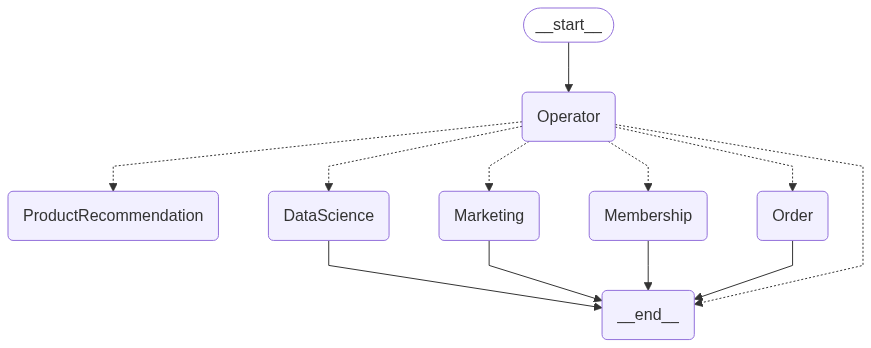

In [77]:
display(Image(graph.get_graph().draw_mermaid_png()))



Response:

 Data Science Agent (CSV Analysis): ### Summary of Your Workout Data

Based on the provided workout data, here are the key statistics and insights:

1. **Workout Overview**:
   - You completed **3 workouts**.
   - The average **output** across these workouts was **275 watts**.
   - The average **cadence** was **87.67 RPM**.
   - The average **resistance** level was **47.67**.
   - The average **speed** was **21.23 km/h**.
   - The average **distance** covered was **8.57 km**.
   - The average **calories burned** was **375 calories**.
   - The average **heart rate** during workouts was **147.67 BPM**.
   - The average **pace** was approximately **2:55 minutes per km**.
   - The average **incline** was **3.5%**.

2. **Performance Metrics**:
   - Your highest output was **300 watts** in workout 2, while the lowest was **250 watts** in workout 1.
   - The highest cadence recorded was **90 RPM** in workout 2, indicating a strong performance.
   - The highest resistance was **50

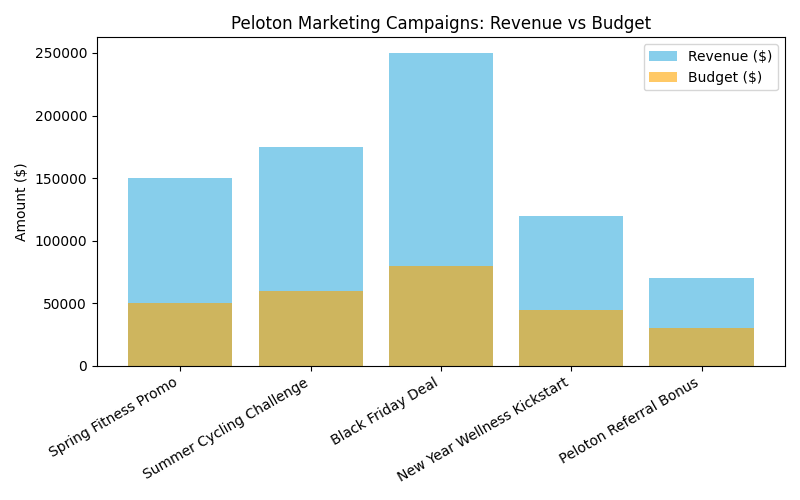



Response:

 Marketing Agent: Here is the revenue vs. budget visualization for Peloton’s marketing campaigns. 




Response:

 Marketing Agent: Absolutely! Here’s a compelling advertising message tailored for someone considering the Tread+ for winter running:

---

**Unlock Your Winter Running Potential with the Peloton Tread+!**

Are you ready to conquer the cold and keep your fitness goals on track this winter? With the Peloton Tread+, you can transform your home into a personal running sanctuary, no matter the weather outside. 

Imagine stepping onto your Tread+ and feeling the rush of adrenaline as you run through immersive scenic routes, all from the comfort of your living room. With its spacious running surface and advanced shock-absorbing technology, the Tread+ provides a safe and comfortable experience, allowing you to push your limits without the risk of icy sidewalks or frigid temperatures.

Plus, with access to live and on-demand classes led by world-class instructors, you’

In [109]:
while True:
    user_input = input("User: ")
    if user_input.lower() in {"q", "quit"}:
        print("Goodbye!")
        break
    result = graph.invoke({"inquiry": user_input})
    
    response = result.get("response", "No Response Returned")
    print(f"\n\nResponse:\n\n {response} \n\n")